# Guide Dog Classifier: Introduction and Setup
Welcome to the Guide Dog Classifier project! This project demonstrates how to classify guide dogs (e.g., Labrador Retrievers, German Shepherds) versus non-guide dogs (e.g., Chihuahuas, Pugs) using transfer learning with EfficientNet-B3 on a 4 GB GPU (RTX 3050 Ti). We aim to achieve 80–85 % accuracy, potentially 90–95 % with fine-tuning, while optimizing memory usage for low-end hardware.




### Why Classify Guide Dogs?
Guide dogs are specially trained to assist visually impaired individuals, requiring specific breeds with traits like intelligence and temperament. Automated classification can streamline training programs and improve accessibility. This project uses the Stanford Dogs dataset to distinguish guide dog breeds from others, showcasing deep learning techniques.

### Notebook Goals  
1. Introduce the dataset and its structure.  
2. Set up the environment (CUDA, PyTorch).  
3. Explore NVIDIA-SMI and memory profiling.  
4. Explain VRAM basics and GPU computing.  
5. Present the EfficientNet-B3 model and test sample images.  
6. Outline the project plan (4 notebooks).  

Let’s dive in!



## Dataset: Stanford Dogs

The dataset is derived from the [Stanford Dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/), containing ~20,582 images across 120+ breeds. We use 2,800 images (1,400 per class):
- **Guide Dogs**: 9 service breeds (e.g., Labrador Retriever, Golden Retriever, German Shepherd).
- **Non-Guide Dogs**: Sampled from 112 non-service breeds (e.g., Chihuahua, Pug).
- **Split**:
  - Train: 1,008 images per class (2,016 total).
  - Validation: 112 images per class (224 total).
  - Test: 280 images per class (560 total).


## Important Note : 
>the dataset isn't available on git.To get the notebooks working you need to **Download** the dataset ( here is the [link](https://drive.google.com/file/d/1mfcb2PY9w_mb2n96PyYDgyJ22qm9mkZb/view?usp=sharing) ) , create a folder called dataset and extract the compressed folder to match the given folder structure. 
### Folder Structure
```bash
dataset
├── train
│   ├── guide_dogs     # 1,008 images
│   ├── non_guide_dogs # 1,008 images
├── val
│   ├── guide_dogs     # 112 images
│   ├── non_guide_dogs # 112 images
├── test
│   ├── guide_dogs     # ~280 images
│   ├── non_guide_dogs # ~280 images
```


Let's verify the dataset and visualize some samples.

In [1]:
import os
# Dataset path
dataset_root = "dataset"

# Count images in each folder
for split in ["train", "val", "test"]:
    for cls in ["guide_dogs", "non_guide_dogs"]:
        folder = os.path.join(dataset_root, split, cls)
        count = len(os.listdir(folder))
        print(f"{split}/{cls}: {count} images")

train/guide_dogs: 1008 images
train/non_guide_dogs: 1008 images
val/guide_dogs: 112 images
val/non_guide_dogs: 112 images
test/guide_dogs: 281 images
test/non_guide_dogs: 281 images


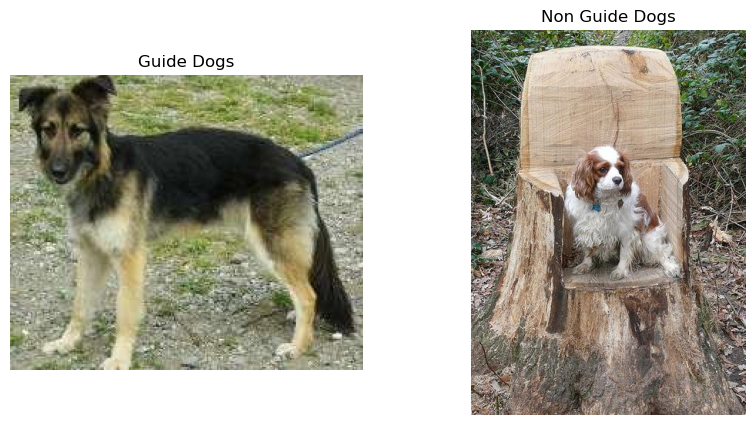

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Display sample images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, cls in enumerate(["guide_dogs", "non_guide_dogs"]):
    folder = os.path.join(dataset_root, "train", cls)
    img_path = os.path.join(folder, os.listdir(folder)[0])  # First image
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(cls.replace("_", " ").title())
    axes[i].axis("off")
plt.show()

### Project Flow and Requirements  

**Project Flow**  
This project is divided into four notebooks:  
1. **0_Introduction_Setup**: problem, dataset, CUDA, EfficientNet-B3 intro  
2. **1_Model_Building_Frozen_Layers**: frozen feature extractor + custom classifier + augmentation
3. **2_Fine_Tuning_No_Optimization**: fine-tune EfficientNet-B3, encounter OOM on 4 GB GPU  
4. **3_Fine_Tuning_Memory_Optimization**: exploring some optimizations techniques. <br> 
**Requirements**  
- Hardware: GPU with CUDA 
- Software: Python 3.8+, PyTorch 1.12+, CUDA 11.3+  
- Knowledge: Basic deep learning  
- Dataset: Pre-partitioned 2 800 images (provided) 

Next, we'll set up CUDA and explore GPU tools.

## CUDA and GPU Computing  
GPUs accelerate deep learning by parallelizing matrix ops. NVIDIA’s CUDA lets PyTorch leverage GPU power, speeding up training versus CPU.  

We’ll verify CUDA availability and set up PyTorch.


In [3]:
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("CUDA is not available. Ensure drivers and CUDA are installed.")


CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
CUDA Version: 12.6
Number of GPUs: 1


## NVIDIA-SMI and Memory Profiling

NVIDIA-SMI (System Management Interface) is a command-line tool to monitor GPU usage, including VRAM (Video Random Access Memory), running processes, and utilization. We'll use it throughout the project to profile memory usage, especially for our 4GB RTX 3050 Ti.

Run `nvidia-smi` in a terminal or below to see current GPU status.

In [5]:
!nvidia-smi

Wed May 21 23:30:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              6W /   60W |      14MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Understanding NVIDIA-SMI Output
- **Memory-Usage**: Current VRAM usage (e.g., 200MiB of 4096MiB).
- **GPU-Util**: GPU computation usage (0% when idle).
- **Processes**: Lists running GPU processes (e.g., Python for PyTorch).

We'll monitor VRAM to optimize training, targeting ~30% memory reduction in the last notebook.

## VRAM Basics

VRAM (Video Random Access Memory) is the GPU’s dedicated memory for storing:
- Model parameters (e.g., weights).
- Input data (e.g., image batches).
- Intermediate activations and gradients during training.

My personal RTX 3050 Ti has **4GB VRAM**, which is limited for deep learning. We'll use NVIDIA-SMI to monitor VRAM and apply techniques like mixed precision and gradient accumulation to stay within 4GB.

# Exploring **EfficientNet-B3**

**EfficientNet-B3** is a convolutional neural network architecture introduced by **Google in 2019**, known for its **high accuracy** and **improved efficiency** over traditional models. It was designed using **Neural Architecture Search (NAS)** and belongs to the scalable **EfficientNet family (B0–B7)**, optimized for performance and resource efficiency.

Unlike traditional CNNs that scale depth, width, or resolution independently, EfficientNet uses **compound scaling**: a principled method to scale all three dimensions together, achieving **superior accuracy/efficiency trade-offs**.


## Why **EfficientNet-B3** for This Project?

- **Pre-trained on ImageNet:** Provides a robust foundation for transfer learning.
- **Moderate size:** **12.3 million parameters** (vs. ~138 million in VGG16), suitable for mid-range hardware with **6–8 GB VRAM**.
- **High accuracy:** Outperforms smaller models like EfficientNet-B0 and rivals larger models on classification tasks.
- **Efficient:** Balances inference and training speed with strong performance, ideal for moderately constrained environments.


## Key Features

- **MBConv blocks:** Mobile inverted bottleneck convolutions, adapted from MobileNetV2.
- **Swish activation:** A smoother activation function than ReLU, enhancing gradient flow.
- **Compound scaling:** Scales depth, width, and resolution using a fixed set of scaling coefficients (**ϕ, α, β, γ**).


| **Model**           | **Params (M)** | **Top-1 Accuracy** | **Input Res** | **VRAM Friendly** |
|---------------------|----------------|--------------------|---------------|-------------------|
| VGG16               | 138            | ~71.5 %            | 224x224       | ❌                |
| ResNet50            | 25.6           | ~76.1 %            | 224x224       | ⚠️                |
| **EfficientNet-B3** | **12.3**       | **~81.6 %**        | **300x300**   | ✅                |


For our **guide dog classification task**, EfficientNet-B3 offers a strong balance of **accuracy, speed, and memory efficiency**, making it suitable for mid-range GPUs like the **RTX 3060 (6 GB)**.

# Exploring architecture

In [2]:
import torchvision.models as models
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1) # Pre-trained weights

## This is the model architecture <br>
<img src="https://www.researchgate.net/publication/348470984/figure/fig4/AS:979961129205762@1610652348424/llustration-of-the-EffecientNet-B3-architecture-10-3646-million-weights-IRC-means.png" alt="research gate">


## Uncomment the Next cell to print the architecture (long input)

In [3]:
# print(model)

# Testing the Model on random images 

In [2]:
import torch
from torchvision import transforms
from PIL import Image
import os, json, requests
import matplotlib.pyplot as plt
import random


model.eval()


# Testing on a guide dog
labels =  models.EfficientNet_B3_Weights.IMAGENET1K_V1.meta["categories"]
transform = models.EfficientNet_B3_Weights.IMAGENET1K_V1.transforms()
randomindex=random.randint(0,1008)

guide="dataset/train/guide_dogs"
img_path = os.path.join(guide, os.listdir(guide)[randomindex])
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0)

with torch.no_grad():
    if torch.cuda.is_available():
        model.cuda()
        img_tensor = img_tensor.cuda()
    output = model(img_tensor)

    _, pred = torch.max(output, 1)


print(f"Predicted class: {labels[pred.item()]}")
plt.imshow(img)
plt.title(f"Predicted: {labels[pred.item()]} (from guide dog dataset)")
plt.axis("off")
plt.show()


# Testing on a non guide dog

labels =  models.EfficientNet_B3_Weights.IMAGENET1K_V1.meta["categories"]
transform = models.EfficientNet_B3_Weights.IMAGENET1K_V1.transforms()
randomindex=random.randint(0,1008)
guide="dataset/train/non_guide_dogs"
img_path = os.path.join(guide, os.listdir(guide)[randomindex])
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0)

with torch.no_grad():
    if torch.cuda.is_available():
        model.cuda()
        img_tensor = img_tensor.cuda()
    output = model(img_tensor)

    _, pred = torch.max(output, 1)


print(f"Predicted class: {labels[pred.item()]}")
plt.imshow(img)
plt.title(f"Predicted: {labels[pred.item()]} (from non guide dog dataset)")
plt.axis("off")
plt.show()

NameError: name 'model' is not defined

## Note

Each notebook resets the cache and kernel for efficiency.

In [7]:
import torch
from IPython import get_ipython
if torch.cuda.is_available():
    torch.cuda.empty_cache()
get_ipython().kernel.do_shutdown(restart=True)


{'status': 'ok', 'restart': True}

## Next Steps
Reset the Jupyter kernel (Kernel > Restart) to clear memory and proceed to `1_Model_Building_Frozen_Layers.ipynb` for model building and training.